In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math 
from sklearn import linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import compress
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import os

parentDirectory = os.path.abspath(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir))
DATA_DIR = parentDirectory +'/data/'
FIGURES_DIR = parentDirectory +'/figures/'

df_agg = pd.read_pickle(DATA_DIR+'df_agg_cats.pickle')
df_mobility = pd.read_csv(DATA_DIR+'df_mobility.csv')

full_names = {
    'AU': 'Australia',
    'BR': 'Brazil',
    'CA': 'Canada',
    'FR': 'France',
    'DE': 'Germany',
    'IN': 'India',
    'IT': 'Italy',
    'MX': 'Mexico',
    'ES': 'Spain',
    'GB': 'United Kingdom',
    'US': 'United States',
    'DK': 'Denmark',
    'KE': 'Kenya', 
    'NG': 'Nigeria',
    'JP': 'Japan',
    'SE': 'Sweden',
    'ID': 'Indonesia',
    'EG': 'Egypt'
}


def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

event_dicts = [{'country': 'AU',
  'end_md_1': '2020-06-07',
  'start_md_1': '2020-03-27',
  'start_md_2': np.nan},
 {'country': 'BR',
  'end_md_1': '2020-08-09',
  'start_md_1': '2020-03-23',
  'start_md_2': np.nan},
 {'country': 'CA',
  'end_md_1': '2020-06-21',
  'start_md_1': '2020-03-19',
  'start_md_2': '2020-10-12'},
 {'country': 'DE',
  'end_md_1': '2020-05-09',
  'start_md_1': '2020-03-21',
  'start_md_2': '2020-12-18'},
 {'country': 'DK',
  'end_md_1': '2020-05-07',
  'start_md_1': '2020-03-17',
  'start_md_2': np.nan},
 {'country': 'EG',
  'end_md_1': '2020-07-01',
  'start_md_1': '2020-03-24',
  'start_md_2': np.nan},
 {'country': 'ES',
  'end_md_1': '2020-06-14',
  'start_md_1': '2020-03-17',
  'start_md_2': '2020-11-07'},
 {'country': 'FR',
  'end_md_1': '2020-06-08',
  'start_md_1': '2020-03-18',
  'start_md_2': '2020-11-01'},
 {'country': 'GB',
  'end_md_1': '2020-08-03',
  'start_md_1': '2020-03-23',
  'start_md_2': '2020-10-21'},
 {'country': 'ID',
  'end_md_1': '2020-08-10',
  'start_md_1': '2020-03-24',
  'start_md_2': np.nan},
 {'country': 'IN',
  'end_md_1': '2020-10-29',
  'start_md_1': '2020-03-24',
  'start_md_2': np.nan},
 {'country': 'IT',
  'end_md_1': '2020-06-06',
  'start_md_1': '2020-03-11',
  'start_md_2': '2020-11-06'},
 {'country': 'JP',
  'end_md_1': '2020-05-30',
  'start_md_1': '2020-04-12',
  'start_md_2': np.nan},
 {'country': 'KE',
  'end_md_1': '2020-10-04',
  'start_md_1': '2020-03-24',
  'start_md_2': np.nan},
 {'country': 'MX',
  'end_md_1': '2020-10-06',
  'start_md_1': '2020-03-25',
  'start_md_2': np.nan},
 {'country': 'NG',
  'end_md_1': '2020-08-09',
  'start_md_1': '2020-03-27',
  'start_md_2': np.nan},
 {'country': 'SE',
  'end_md_1': '2020-04-09',
  'start_md_1': '2020-04-03',
  'start_md_2': np.nan},
 {'country': 'US',
  'end_md_1': '2020-06-11',
  'start_md_1': '2020-03-21',
  'start_md_2': '2020-11-26'}]

df_events = pd.DataFrame(event_dicts)
df_events['start_md_1'] = pd.to_datetime(df_events['start_md_1'])
df_events['end_md_1'] = pd.to_datetime(df_events['end_md_1'])
df_events['start_md_2'] = pd.to_datetime(df_events['start_md_2'])

In [2]:
df_agg = df_agg.loc[df_agg['country'].isin(full_names.keys())]
studied_weeks = list(df_agg.iloc[0]['volume_weekly_total'].index)[-46:]

mobility_ts = {}

for country, gr in df_mobility.groupby('country_region_code'):
    mobility_dict = {}
    gr = gr.iloc[1:323]
    for i in chunker(gr,7):
        mobility_dict[i.iloc[0]['date']] = (i['residential_percent_change_from_baseline'].mean())
    mobility_ts[country] = mobility_dict

### Ranks

In [3]:
df_agg['category'].unique()

array(['dessert', 'soft drink', 'rice dish', 'soup', 'spice',
       'wine, beer and liquor', 'fruit', 'fish dish', 'cheese',
       'pork dish', 'vegetable and legume', 'lamb dish', 'herb', 'snack',
       'beef dish', 'pie', 'pasta, pizza and noodle dish',
       'bread and flatbread', 'potato dish', 'stew', 'egg dish', 'sauce',
       'chicken dish', 'cocktail', 'salad', 'sandwich', 'sausage',
       'pastry and bakery product'], dtype=object)

In [4]:
list_entries = []

for week in df_agg.iloc[0]['volume_weekly_total'].index:
    for cat,gr in df_agg.groupby('category'):
        entry = {}
        entry['week'] = week
        entry['category'] = cat
        entry['sum'] = gr['volume_weekly_total'].apply(lambda x: x[week]).sum()
        list_entries.append(entry)

In [5]:
df_ranks = pd.DataFrame(list_entries)

In [6]:
df_ranks['rank'] = df_ranks.groupby("week")["sum"].rank("dense", ascending=True) / 28


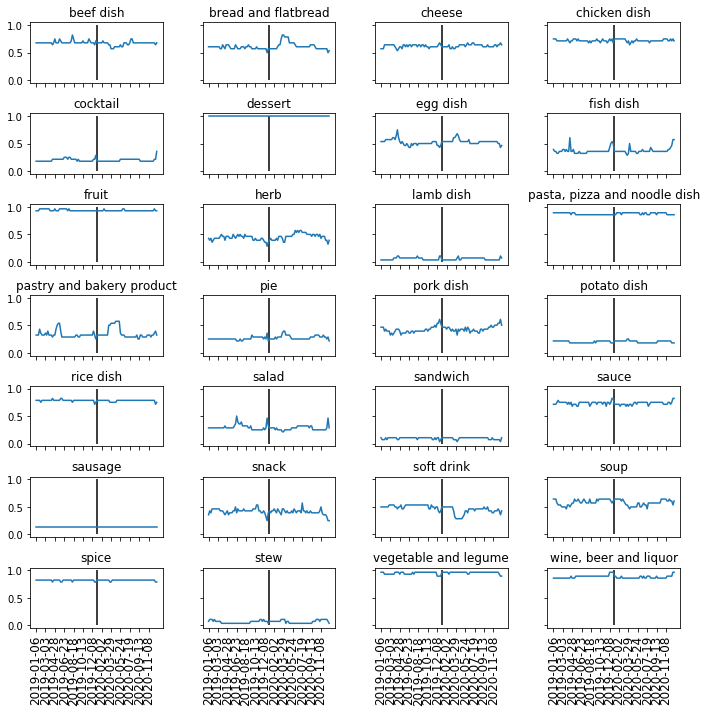

In [7]:
fig, ax = plt.subplots(7,4,figsize= (10,10), sharex = True, sharey = True)
cnt = 0
for c,gr in df_ranks.groupby('category'):
    sbplt = ax[math.floor (cnt/4), cnt%4]

    sbplt.plot(gr['rank'].values, label = c)
    cnt+=1
    sbplt.set_title(c)
    sbplt.set_xticks(range(104)[::8])
    sbplt.set_xticklabels(np.concatenate((df_agg.iloc[0]['volume_weekly_total'].index[::8],
                                     [df_agg.iloc[0]['volume_weekly_total'].index[-1]])), rotation = 90, size= 12)
    
    sbplt.vlines(52,0,1)
plt.tight_layout()

In [8]:
entry_list_first_wave = []
entry_list_second_wave = []

for category, gr1 in df_agg.groupby('category'):
    #print(category)
    for country, gr2 in gr1.groupby('country'):
        entry = {}
        #print(country)
        
        x = (gr2['volume_weekly_total'].values[0][-46:].values - gr2['volume_weekly_total'].values[0][-98:-52].values)/gr2['volume_weekly_total'].values[0][-98:-52].values
        y = mobility_ts[country]


        entry['category'] = category
        entry['corr'] = spearmanr(x, list(y.values()))[0]
        entry['p'] = spearmanr(x, list(y.values()))[1]
        
        entry['country'] = country
        
        entry_list_first_wave.append(entry.copy())

df_plot_w_1 = pd.DataFrame(entry_list_first_wave)

/Users/gligoric/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [9]:
df_plot_w_1['wave'] = ['First wave']*len(df_plot_w_1)

order = list(df_plot_w_1.groupby('category').agg('mean').sort_values(by = 'corr').index[::-1])

temp_df1 = pd.DataFrame({'category': order, 
                        'category_id':2*np.array(range(len(order)))})

df_plot_w_1_a = df_plot_w_1.merge(temp_df1, on='category', how='left')

df_plot_w_1_a['category_id'] = df_plot_w_1_a['category_id'].astype(int)


In [10]:
df_plot_w_1_a.loc[df_plot_w_1_a['category']=='wine, beer and liquor'].sort_values(by = 'corr')

,category,corr,p,country,wave,category_id
493,"wine, beer and liquor",-0.611641,6.304921e-06,FR,First wave,46
498,"wine, beer and liquor",-0.380688,9.054666e-03,JP,First wave,46
490,"wine, beer and liquor",-0.343902,1.927624e-02,DK,First wave,46
502,"wine, beer and liquor",-0.283670,5.607633e-02,SE,First wave,46
492,"wine, beer and liquor",0.039351,7.951354e-01,ES,First wave,46
489,"wine, beer and liquor",0.113702,4.518175e-01,DE,First wave,46
486,"wine, beer and liquor",0.128123,3.961249e-01,AU,First wave,46
491,"wine, beer and liquor",0.150881,3.168732e-01,EG,First wave,46
495,"wine, beer and liquor",0.213290,1.546703e-01,ID,First wave,46
497,"wine, beer and liquor",0.223154,1.360340e-01,IT,First wave,46


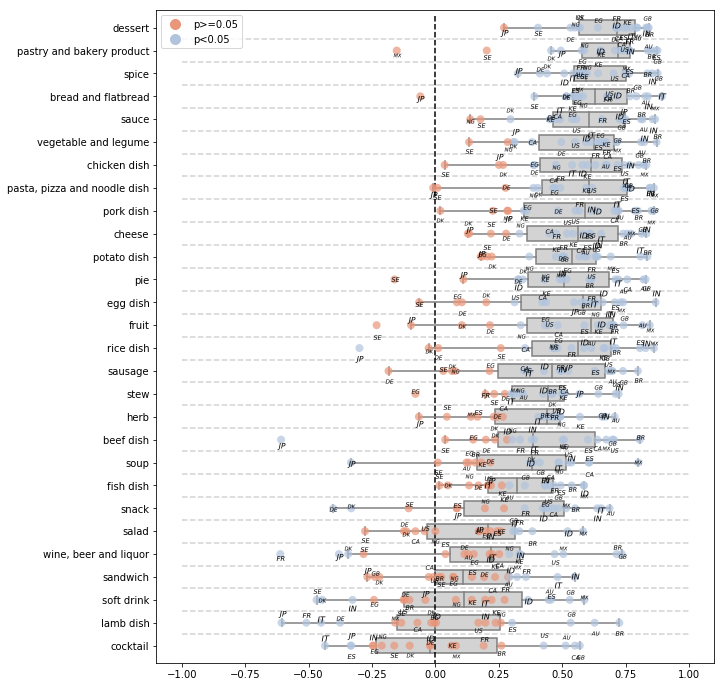

In [11]:
df_plot_w_1_a['p<0.05'] = df_plot_w_1_a['p'].apply(lambda x: 'p<0.05' if x <0.05 else 'p>=0.05')

f, ax = plt.subplots(figsize=(10,12))


sns.boxplot(x="corr", y="category_id", data=df_plot_w_1_a, orient = 'h',  width = 1.3,
            color = 'lightgray', order=np.arange(2*29), showfliers=False)

red_patch = mpatches.Patch(color='tab:red', label='First wave')
blue_patch = mpatches.Patch(color='tab:blue', label='Second wave')


sc1 = Line2D([0], [0], marker='o', color='darksalmon', label='p>=0.05', linestyle = 'None',
                          markerfacecolor='darksalmon', markersize=10)
sc2 = Line2D([0], [0], marker='o', color='lightsteelblue', label='p<0.05', linestyle = 'None',
                          markerfacecolor='lightsteelblue', markersize=10)


#plt.legend(handles=[red_patch, blue_patch])

sns.stripplot(x="corr", y="category_id", hue = 'p<0.05',data=df_plot_w_1_a, orient = 'h',
            size = 8, marker = 'o',edgecolor='gray',alpha = 0.7,palette=['lightsteelblue','darksalmon'], order=np.arange(2*29), jitter = 0)
#'darkseagreen','sandybrown'
for n,gr in df_plot_w_1_a.groupby('country'):
    sns.stripplot(x="corr", y="category_id", hue = 'p<0.05',data=gr, orient = 'h',
            size = 8, marker = '$'+ n +'$',palette=['black','black'], order=np.arange(2*29), jitter = 1.01)


plt.legend(handles=[sc1, sc2])



for i in range(1,27*2)[::2]:
    plt.hlines(i,-1,1,linestyle ='--',color = 'lightgray')
            
             #width=0.5

plt.yticks(np.arange(2*29)[::2], order);
plt.ylim([28*2-0.5, -1.50])
plt.vlines(0,-1,56, linestyle = '--',color = 'black')
plt.ylabel('')
plt.xlabel("");

plt.savefig(FIGURES_DIR+"corr_two_waves.pdf", bbox_inches='tight')

In [12]:
df_plot_w_1_a.loc[df_plot_w_1_a['category']=='cocktail'].sort_values(by='corr')

,category,corr,p,country,wave,category_id,p<0.05
83,cocktail,-0.435638,0.002478,IT,First wave,54,p<0.05
84,cocktail,-0.333951,0.023318,JP,First wave,54,p<0.05
78,cocktail,-0.332449,0.023986,ES,First wave,54,p<0.05
82,cocktail,-0.247440,0.097331,IN,First wave,54,p>=0.05
77,cocktail,-0.243839,0.102461,EG,First wave,54,p>=0.05
87,cocktail,-0.211887,0.157466,NG,First wave,54,p>=0.05
88,cocktail,-0.162379,0.280956,SE,First wave,54,p>=0.05
76,cocktail,-0.101536,0.501942,DK,First wave,54,p>=0.05
75,cocktail,-0.021346,0.888021,DE,First wave,54,p>=0.05
81,cocktail,-0.020916,0.890266,ID,First wave,54,p>=0.05


In [13]:
entry_list_first_wave = []
entry_list_second_wave = []

for category, gr1 in df_agg.groupby('category'):
    #print(category)
    for country, gr2 in gr1.groupby('country'):
        entry = {}
        #print(country)
        
        x = (gr2['volume_weekly_total'].values[0][-46:].values - gr2['volume_weekly_total'].values[0][-98:-52].values)/gr2['volume_weekly_total'].values[0][-98:-52].values
        y = mobility_ts[country]

        
        entry['category'] = category
        entry['corr'] = pearsonr(x, list(y.values()))[0]
        entry['p'] = pearsonr(x, list(y.values()))[1]
        
        entry['country'] = country
        
        entry_list_first_wave.append(entry.copy())

df_plot_w_1 = pd.DataFrame(entry_list_first_wave)

df_plot_w_1['wave'] = ['First wave']*len(df_plot_w_1)

order = list(df_plot_w_1.groupby('category').agg('mean').sort_values(by = 'corr').index[::-1])

temp_df1 = pd.DataFrame({'category': order, 
                        'category_id':2*np.array(range(len(order)))})

df_plot_w_1_a = df_plot_w_1.merge(temp_df1, on='category', how='left')

df_plot_w_1_a['category_id'] = df_plot_w_1_a['category_id'].astype(int)


/Users/gligoric/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/gligoric/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3007: RuntimeWarning: invalid value encountered in subtract
  xm, ym = x - mx, y - my
/Users/gligoric/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3008: RuntimeWarning: invalid value encountered in reduce
  r_num = np.add.reduce(xm * ym)


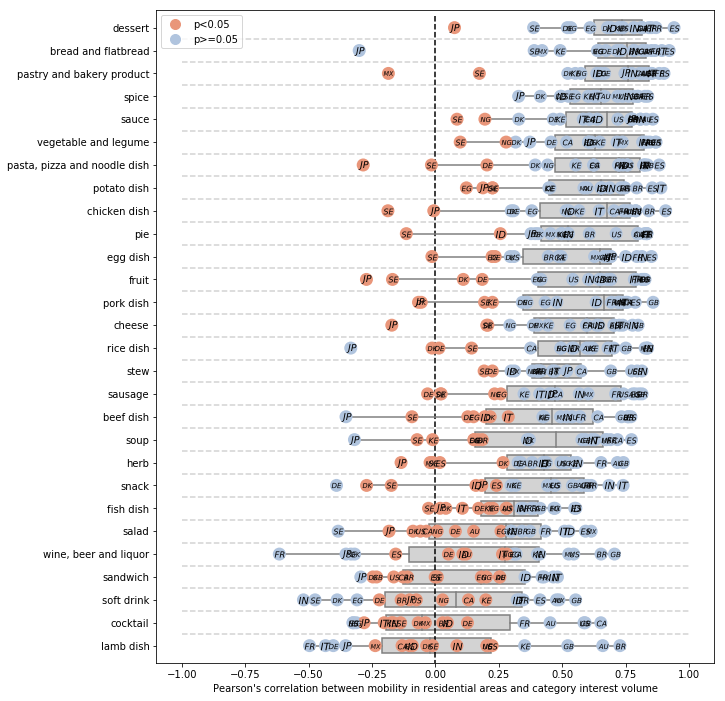

In [14]:
df_plot_w_1_a['p<0.05'] = df_plot_w_1_a['p'].apply(lambda x: 'p<0.05' if x <0.05 else 'p>=0.05')

f, ax = plt.subplots(figsize=(10,12))


sns.boxplot(x="corr", y="category_id", data=df_plot_w_1_a, orient = 'h',  width = 1.3,
            color = 'lightgray', order=np.arange(2*29), showfliers=False)

red_patch = mpatches.Patch(color='darksalmon', label='First wave')
blue_patch = mpatches.Patch(color='lightsteelblue', label='Second wave')


sc1 = Line2D([0], [0], marker='o', color='darksalmon', label='p<0.05', linestyle = 'None',
                          markerfacecolor='darksalmon', markersize=10)
sc2 = Line2D([0], [0], marker='o', color='lightsteelblue', label='p>=0.05', linestyle = 'None',
                          markerfacecolor='lightsteelblue', markersize=10)


#plt.legend(handles=[red_patch, blue_patch])

sns.stripplot(x="corr", y="category_id", hue = 'p<0.05',data=df_plot_w_1_a, orient = 'h',
            size = 13, marker = 'o',palette=['lightsteelblue','darksalmon'], order=np.arange(2*29), jitter = 0)
#'darkseagreen','sandybrown'
for n,gr in df_plot_w_1_a.groupby('country'):
    sns.stripplot(x="corr", y="category_id", hue = 'p<0.05',data=gr, orient = 'h',
            size = 10, marker = '$'+ n +'$',palette=['black','black'], order=np.arange(2*29), jitter = 0)


plt.legend(handles=[sc1, sc2])



for i in range(1,27*2)[::2]:
    plt.hlines(i,-1,1,linestyle ='--',color = 'lightgray')
            
             #width=0.5

plt.yticks(np.arange(2*29)[::2], order);
plt.ylim([28*2-0.5, -1.50])
plt.vlines(0,-1,56, linestyle = '--',color = 'black')
plt.ylabel('')
plt.xlabel("Pearson's correlation between mobility in residential areas and category interest volume");

plt.savefig(FIGURES_DIR+"appendix_pearson_cats.pdf", bbox_inches='tight')